In [3]:
import allel
import loompy
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
from collections import defaultdict

from sklearn.manifold import TSNE as tsne
from sklearn.cluster import KMeans as kmeans

import mb_funcs as mb
%load_ext autoreload
%autoreload 2

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
mb_loomfile = '/n/fs/ragr-data/datasets/4-cell-lines-AML-CNV/4-cell-lines-AML-CNV.loom'

with loompy.connect(mb_loomfile) as ds:
    print(ds.attrs.keys())
    print(ds.shape)

['CreationDate', 'LOOM_SPEC_VERSION', 'allsites_block', 'chemistry', 'chunks', 'coverage', 'genome_version', 'last_modified', 'mb_loom_version', 'n_reads', 'n_reads_per_cell', 'version']
(33439, 1241)


In [5]:
ds = loompy.connect(mb_loomfile)

In [ ]:
# ds.close()

#### data overview

In [6]:
for key in ds.attrs.keys():
    print(f'{key}: {ds.attrs[key]}')

CreationDate: 20190906T073516.119759Z
LOOM_SPEC_VERSION: 2.0.1
allsites_block: 332
chemistry: V2
chunks: ['(64, 64)']
coverage: 30
genome_version: hg19
last_modified: 20190906T073516.069735Z
mb_loom_version: 2.2
n_reads: 7519159
n_reads_per_cell: 3850
version: ['0.2.0']


In [7]:
ds.layers.keys()

['', 'AD', 'DP', 'GQ', 'RO']

In [8]:
def generate_heatmap(data):
#     fig, ax = plt.subplots(1,1)
    g = sns.clustermap(data, row_cluster=False, col_cluster=False)
    g.ax_heatmap.set_ylabel('SNVs', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### What is the number of cells, positions, amplicons?

In [9]:
print(f"number of covered positions is {ds.shape[0]}")
print(f"number of cells is {ds.shape[1]}")
print(f"number of amplicons is {len(np.unique(ds.ra['amplicon']))}")
print(f"number of chromosomes is {len(np.unique(ds.ra['CHROM']))}")

number of covered positions is 33439
number of cells is 1241
number of amplicons is 127
number of chromosomes is 14


#### Q: what is nonref_cells in row attributes?

In [10]:
ds.ra.keys()

['ALT',
 'CHROM',
 'CLNDEF',
 'COMMON',
 'POS',
 'QUAL',
 'REF',
 'RSID',
 'amplicon',
 'id',
 'nonref_cells']

In [11]:
pd.Series(ds.ra['nonref_cells']).value_counts()

1.0      11364
0.0       7697
2.0       5866
3.0       3431
4.0       2133
         ...  
36.0         1
175.0        1
164.0        1
445.0        1
107.0        1
Length: 100, dtype: int64

#### position dataframe

In [12]:
df_pos = pd.DataFrame({'pos': list(ds.ra['POS']),
                       'chrom': list(ds.ra['CHROM']),
                       'amplicon': list(ds.ra['amplicon']),
                       'ref': list(ds.ra['REF']),
                       'alt': list(ds.ra['ALT'])})

df_pos['ref_len'] = df_pos['ref'].apply(len)
df_pos['alt_len'] = df_pos['alt'].apply(len)
df_pos['normal'] = (df_pos['ref_len'] == 1) & (df_pos['alt_len'] == 1)

df_pos['index'] = df_pos.index

In [13]:
df_pos

pos chrom               amplicon ref          alt  ref_len  \
0      115256669     1  AML_v2_NRAS_115256512   G            A        1   
1      115256669     1  AML_v2_NRAS_115256512   G  GATGCTATTGC        1   
2      115256683     1  AML_v2_NRAS_115256512   A            G        1   
3      115256683     1  AML_v2_NRAS_115256512   A            C        1   
4      115258637     1  AML_v2_NRAS_115258635   A            T        1   
...          ...   ...                    ...  ..          ...      ...   
33434   44524606    21  AML_v2_U2AF1_44524438   T            C        1   
33435   44524607    21  AML_v2_U2AF1_44524438   A            G        1   
33436   44524607    21  AML_v2_U2AF1_44524438   A            T        1   
33437   44524608    21  AML_v2_U2AF1_44524438   A            G        1   
33438   44524609    21  AML_v2_U2AF1_44524438   C            A        1   

       alt_len  normal  index  
0            1    True      0  
1           11   False      1  
2            1    True      2  
3            1    True      3  
4            1    True      4  
...        ...     ...    ...  
33434        1    True  33434  
33435        1    True  33435  
33436        1    True  33436  
33437        1    True  33437  
33438        1    True  33438  

[33439 rows x 9 columns]

(array([1.446e+04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.479e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

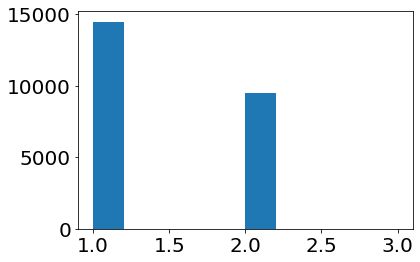

In [14]:
plt.hist(df_pos.groupby(['pos', 'amplicon'])['index'].count().values)

In [15]:
df_unique_pos = df_pos.groupby(['pos', 'amplicon']).last().reset_index()

In [16]:
len(df_unique_pos)

23946

In [17]:
df_unique_pos

pos               amplicon chrom ref alt  ref_len  alt_len  \
0        5073727    AML_v2_JAK2_5073725     9   C   T        1        1   
1        5073728    AML_v2_JAK2_5073725     9   A   G        1        1   
2        5073729    AML_v2_JAK2_5073725     9   A   G        1        1   
3        5073730    AML_v2_JAK2_5073725     9   G            1        0   
4        5073731    AML_v2_JAK2_5073725     9   C   T        1        1   
...          ...                    ...   ...  ..  ..      ...      ...   
23941  209113271  AML_v2_IDH1_209113110     2   T   A        1        1   
23942  209113272  AML_v2_IDH1_209113110     2   C   T        1        1   
23943  209113273  AML_v2_IDH1_209113110     2   A   C        1        1   
23944  209113274  AML_v2_IDH1_209113110     2   G   A        1        1   
23945  209113275  AML_v2_IDH1_209113110     2   G   A        1        1   

       normal  index  
0        True  20699  
1        True  20700  
2        True  20701  
3       False  20702  
4        True  20703  
...       ...    ...  
23941    True   6532  
23942    True   6534  
23943    True   6536  
23944    True   6537  
23945    True   6538  

[23946 rows x 9 columns]

#### What is the actual number of positions?

In [18]:
print(f"Total number of positions is {len(df_unique_pos)}")

Total number of positions is 23946


#### What is the number of positions covered in each chromosome?

In [19]:
df_unique_pos['chrom'].value_counts()

4     6906
2     4153
7     2547
12    1812
17    1721
20    1670
13    1588
21    1146
11     898
3      576
1      352
5      223
15     208
9      146
Name: chrom, dtype: int64

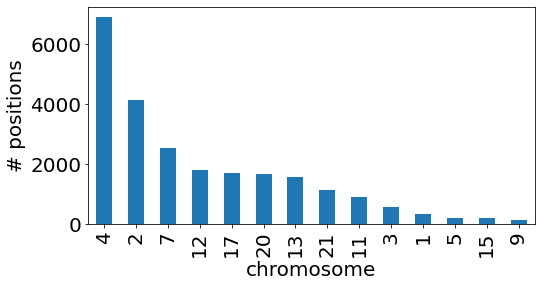

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# positions');

#### what is the number of amplicons in each chromosome?

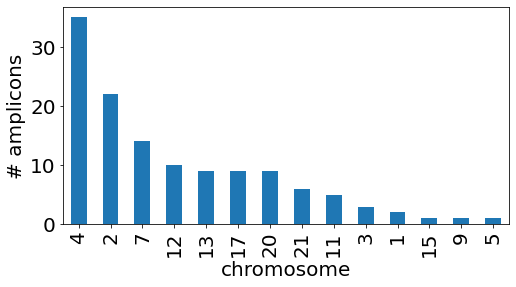

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos.groupby('amplicon').first()['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# amplicons');

#### what is the number of positions in each amplicon

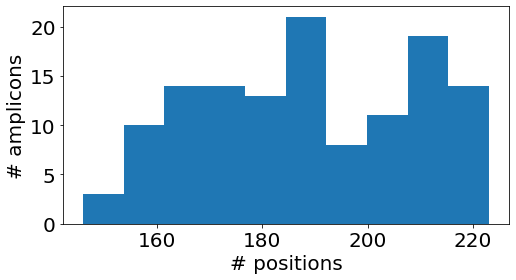

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['amplicon'].value_counts().plot.hist()
plt.gca().set_ylabel('# amplicons');
plt.gca().set_xlabel('# positions');

#### what is the coverage across cells?

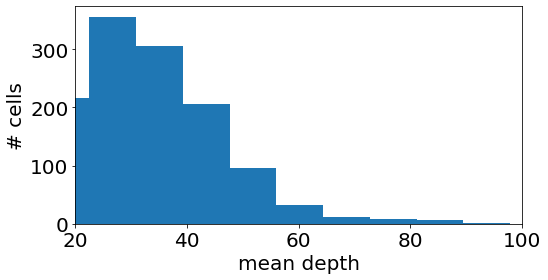

In [23]:
(mean_coverage, ) = ds.layers['DP'].map([np.mean], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(mean_coverage);
plt.gca().set_xlabel('mean depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

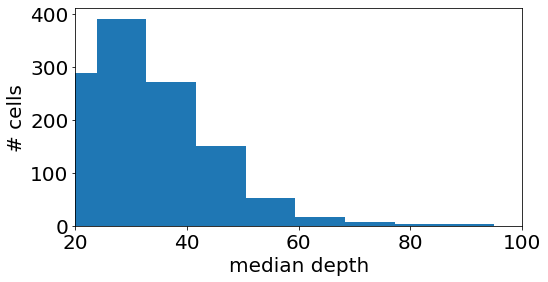

In [24]:
(median_coverage, ) = ds.layers['DP'].map([np.median], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(median_coverage);
plt.gca().set_xlabel('median depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

#### how much does read depth vary within each amplicon?

For each cell $i$ we look at the max read depth $M_{ij}$ and the min read depth $m_{ij}$ across all positions in amplicon $j$. <br>
Then we compute $m_{ij}/M_{ij}$. This is the most extreme factor by which the copy number estimate will vary for positions within amplicon $j$ in cell $i$.

We expect this number to be close to 1 because the read lengths should be comparable with the amplicon lengths. <br>

In [25]:
amplicon_list = list(df_unique_pos['amplicon'].unique())

namplicons = len(amplicon_list)

df_unique_pos = df_unique_pos.sort_values('index')

In [26]:
trim_perc = 0
empty_cells_median = np.zeros((namplicons, 1))

for idx, amplicon in enumerate(amplicon_list):
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values
    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0
    
    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]

    median_depths = np.median(a, axis = 0)
    empty_cells_median[idx] = sum(median_depths == 0)

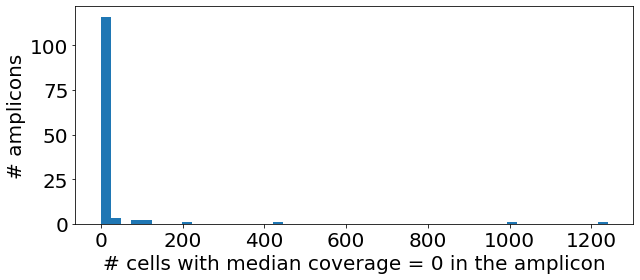

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.hist(empty_cells_median, bins = 50)
plt.gca().set_ylabel('# amplicons', fontsize=20)
plt.gca().set_xlabel('# cells with median coverage = 0 in the amplicon', );

In [28]:
def plot_amplicon_coverage(curr_amplicon, nprobe = 5, trim_perc = 0, read_threshold = 0):
    amplicon_idx = amplicon_list.index(curr_amplicon)
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == curr_amplicon]['index'].values

    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0
    
    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    
    
    median_depths = np.median(a, axis = 0)
    a_filtered = a[:, median_depths > read_threshold]
    a_filtered_normalized = a_filtered / np.median(a_filtered, axis = 0)
    print(f"rejected {a.shape[1] - a_filtered_normalized.shape[1]} cells for amplicon {curr_amplicon}")
    
    np.random.seed(int(curr_amplicon.split('_')[-1]))
    
    fig, ax = plt.subplots(1,1,figsize=(10,4))
        
    if nprobe > 0:
        cell_idx = np.random.randint(a_filtered_normalized.shape[1], size = nprobe)    
        plt.plot(a_filtered_normalized[:,cell_idx], linewidth=3)
    else:
        cell_idx = np.random.randint(a_filtered_normalized.shape[1], size = nprobe)    
        plt.plot(a_filtered_normalized[:, :], 'k', linewidth=3, alpha = 0.05)        
    plt.title(f'{curr_amplicon} coverage for {nprobe} random cells from organoid', fontsize=20)
    plt.gca().set_ylabel('normalized depth')
    plt.gca().set_xlabel('index of position in the amplicon')    

rejected 29 cells for amplicon AML_v2_JAK2_5073725
rejected 3 cells for amplicon AML_v2_TP53_7577035
rejected 4 cells for amplicon AML_v2_DNMT3A_25467033
rejected 2 cells for amplicon AML_v2_ASXL1_31022741
rejected 3 cells for amplicon AML_v2_PTPN11_112926226


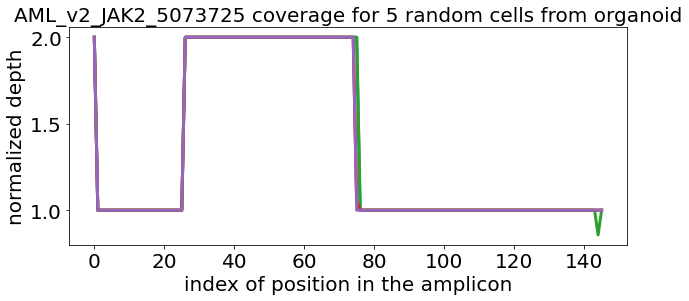

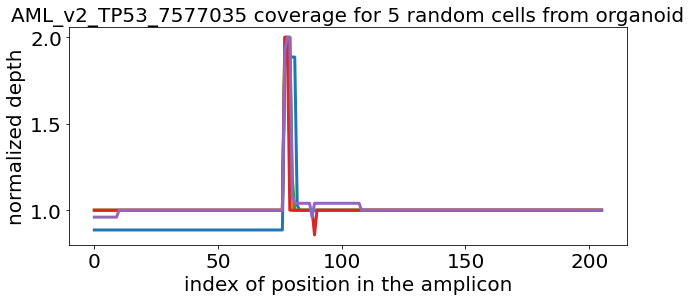

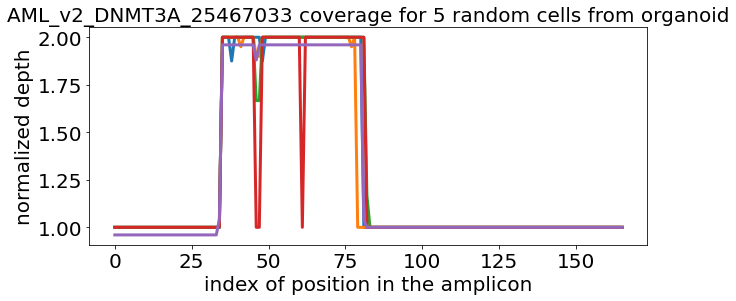

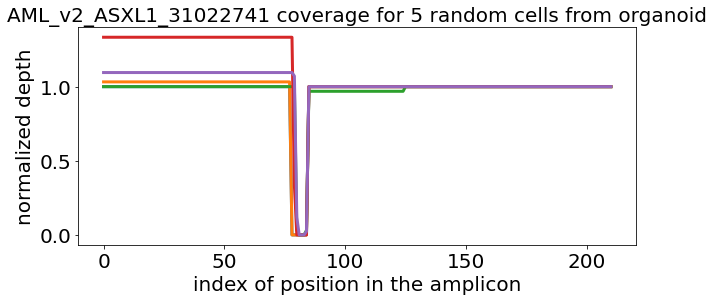

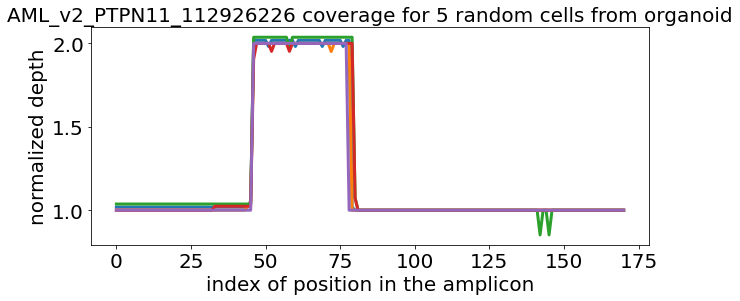

In [29]:
plot_amplicon_coverage(amplicon_list[0])
plot_amplicon_coverage(amplicon_list[4])
plot_amplicon_coverage(amplicon_list[20])
plot_amplicon_coverage(amplicon_list[43])
plot_amplicon_coverage(amplicon_list[100])

rejected 29 cells for amplicon AML_v2_JAK2_5073725
rejected 3 cells for amplicon AML_v2_TP53_7577035
rejected 4 cells for amplicon AML_v2_DNMT3A_25467033
rejected 2 cells for amplicon AML_v2_ASXL1_31022741
rejected 3 cells for amplicon AML_v2_PTPN11_112926226


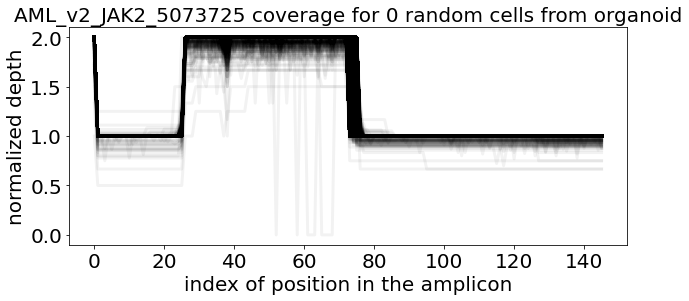

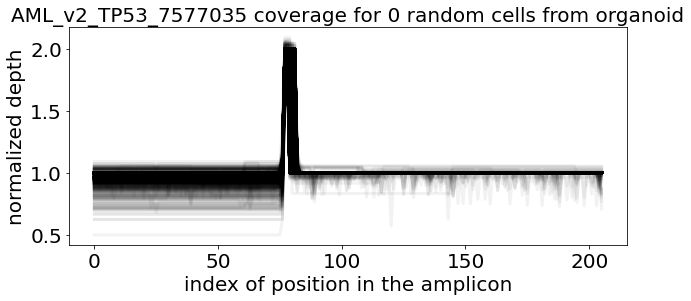

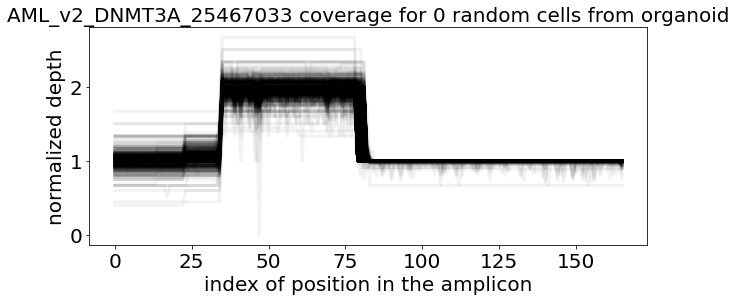

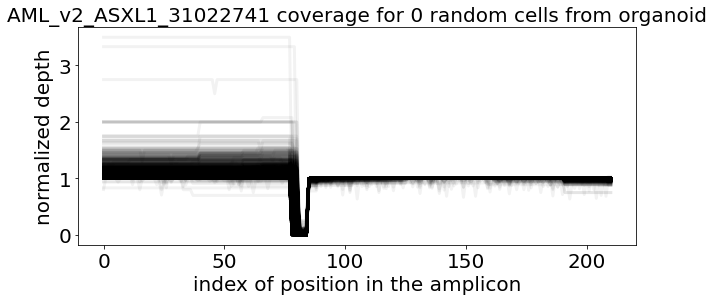

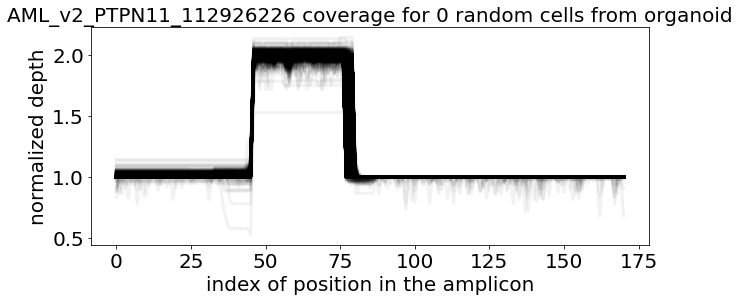

In [30]:
plot_amplicon_coverage(amplicon_list[0], nprobe = 0)
plot_amplicon_coverage(amplicon_list[4], nprobe = 0)
plot_amplicon_coverage(amplicon_list[20], nprobe = 0)
plot_amplicon_coverage(amplicon_list[43], nprobe = 0)
plot_amplicon_coverage(amplicon_list[100], nprobe = 0)

In [31]:
def plot_cell_coverage(cell_idx, nprobe = None, norm_flag = True, trim_perc = 0):

    depth_values = []
    pos_values = []
    prev_npos = 0
    breakpoint_locs = []
    namplicon = len(amplicon_list)
    if nprobe:
        np.random.seed(cell_idx)
        selected_amplicon_list = [amplicon_list[x] for x in np.random.randint(namplicon, size=nprobe)]
    else:
        selected_amplicon_list = amplicon_list.copy()
        
    for amplicon in selected_amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], cell_idx]    


        if norm_flag:
            median_depth =  np.median(a)
            if median_depth == 0:
                a = np.zeros(a.shape)
            else:
                a = a / np.median(a)

        depth_values += list(a)
        pos_values += list(prev_npos + np.arange(npos))
        prev_npos += npos
        breakpoint_locs.append(prev_npos)
        
    fig, ax = plt.subplots(1,1,figsize=(40,4))
    plt.plot(pos_values, depth_values, linewidth=3)
    for idx in range(len(selected_amplicon_list)):
        plt.axvline(breakpoint_locs[idx], color='r')

    plt.gca().set_ylabel('read depth')
    plt.gca().set_xlabel('position index')  
    plt.xlim((0, prev_npos))
    
    if not nprobe:
        plt.title(f"coverage for all amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)
    else:
        plt.title(f"coverage for {nprobe} random amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)

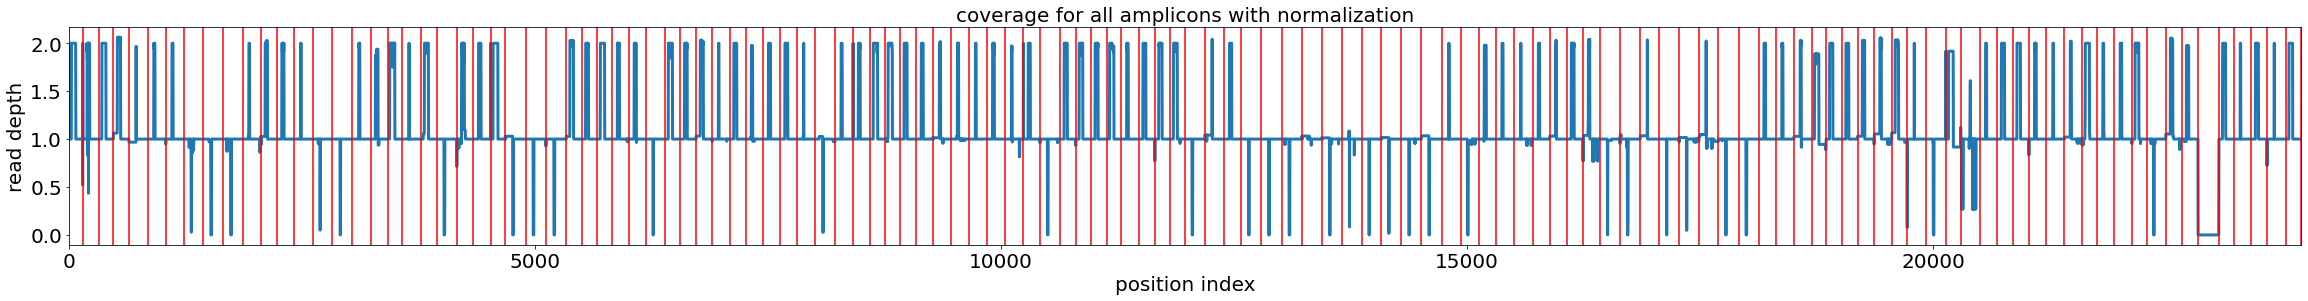

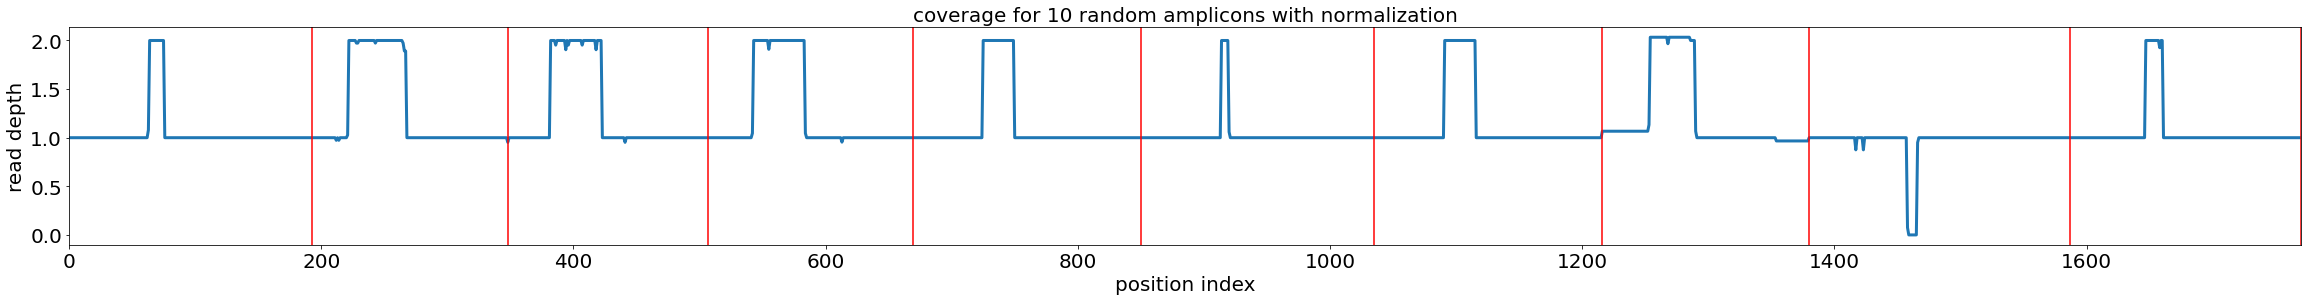

In [32]:
plot_cell_coverage(0)
plot_cell_coverage(0, nprobe = 10)

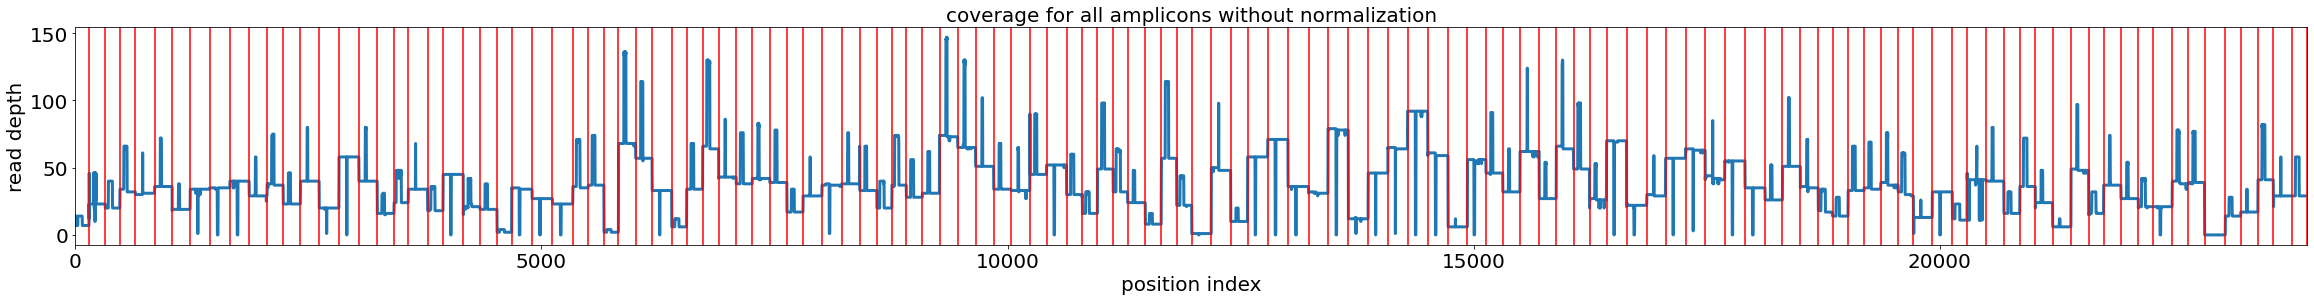

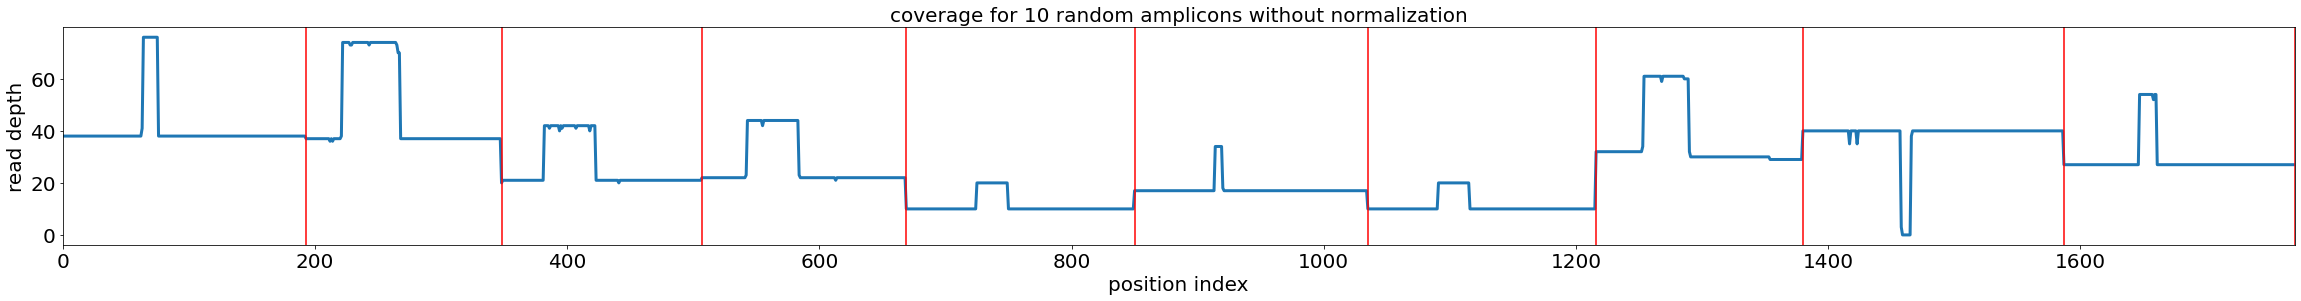

In [33]:
plot_cell_coverage(0, norm_flag=False)
plot_cell_coverage(0, nprobe = 10, norm_flag=False)

In [34]:
probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9]

In [35]:
def plot_quantile_distribution(probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9], trim_perc = 0, read_depth_threshold = 0):

    qrecord = None
    for amplicon in amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        median_depths = np.median(a, axis = 0)
        a_filtered = a[:, median_depths > read_depth_threshold]
        a_filtered_normalized = a_filtered / np.median(a_filtered, axis = 0)

        if qrecord is not None:
            qrecord = np.hstack((qrecord, np.quantile(a_filtered_normalized, probe_quantile, axis = 0)))
        else:
            qrecord = np.quantile(a_filtered_normalized, probe_quantile, axis = 0)
        
    return qrecord
#     for idx in len(probe_quantile):
#         fig, ax = plt.subplots(1,1,figsize=(6,4))
#         plt.hist(qrecord[idx,:], bins = 20)
#         plt.gca().set_ylabel(f"({probe_quantile[idx]}th quantile)/median")
#         plt.gca().set_xlabel(f"# amplicons across cells")

In [36]:
qrecord = plot_quantile_distribution()

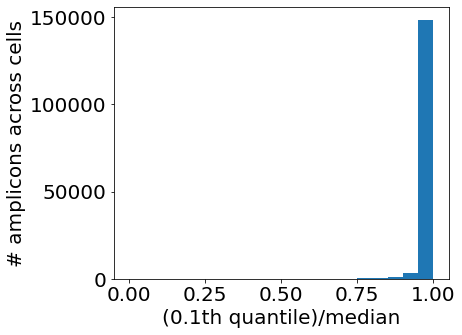

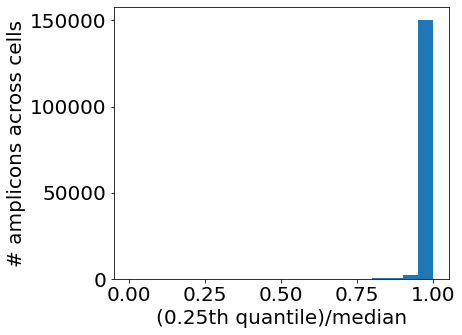

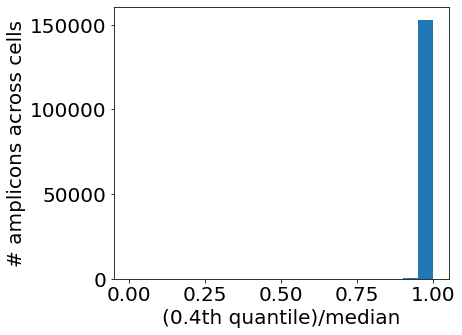

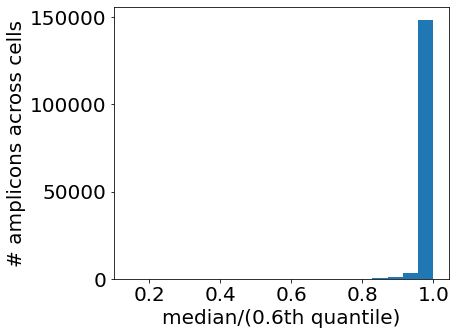

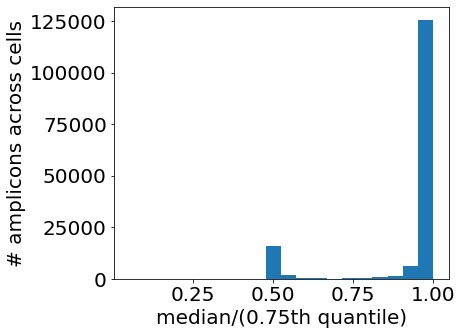

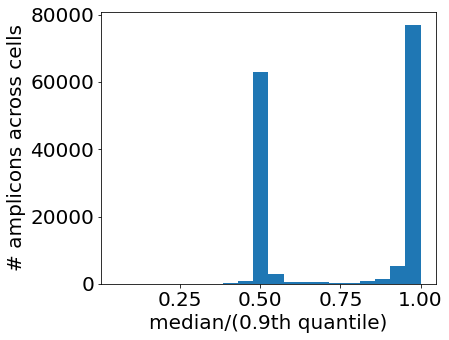

In [37]:
for idx in range(len(probe_quantile)):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    if probe_quantile[idx] > 0.5:
        plt.hist(np.reciprocal(qrecord[idx,:]), bins = 20)
        plt.gca().set_xlabel(f"median/({probe_quantile[idx]}th quantile)")
    else:
        plt.hist(qrecord[idx,:], bins = 20)
        plt.gca().set_xlabel(f"({probe_quantile[idx]}th quantile)/median")
    plt.gca().set_ylabel(f"# amplicons across cells")
#     if probe_quantile[idx] > 0.5:
#         plt.xlim((1,15))

In [40]:
def get_read_depth_heatmap(amplicon_threshold = 0, trim_perc = 0, read_depth_threshold = 0):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]

    return read_depth

In [41]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0.5, read_depth_threshold = 10)

In [42]:
read_depth.shape

(127, 1239)

In [43]:
np.sum(read_depth, axis = 0).shape

(1239,)

In [44]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 28.0, 'cells')

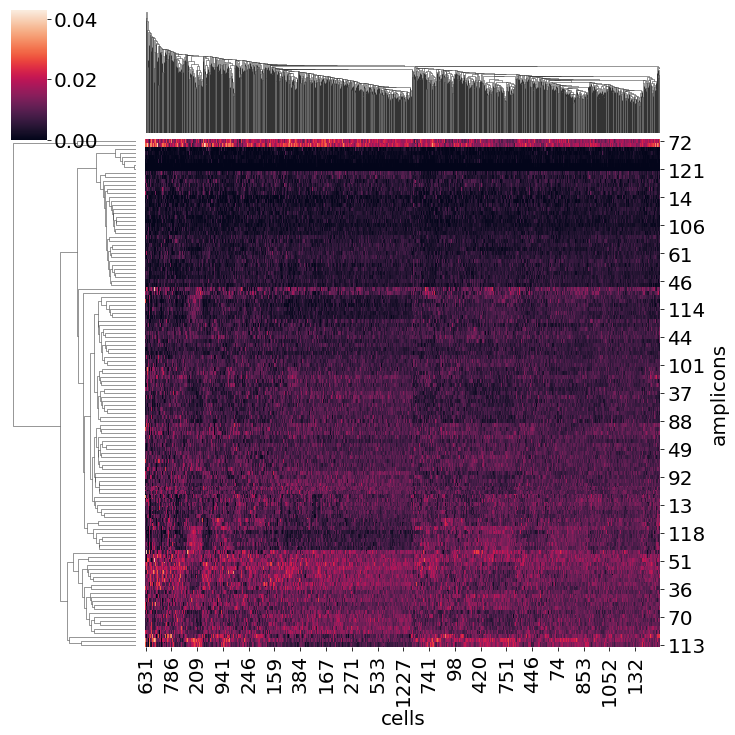

In [45]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### lets try clustering of normalized read depth

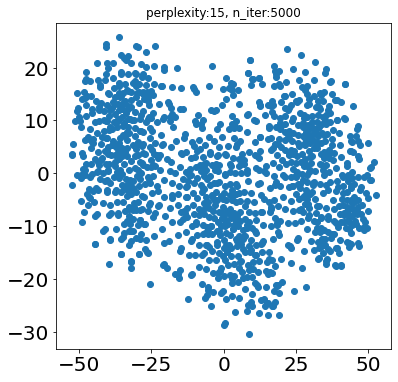

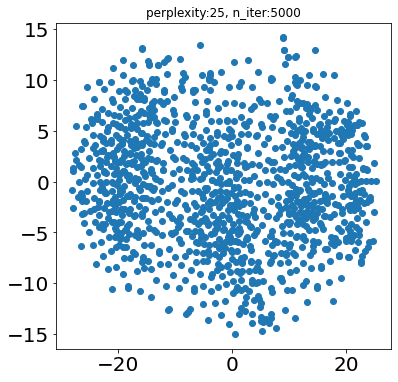

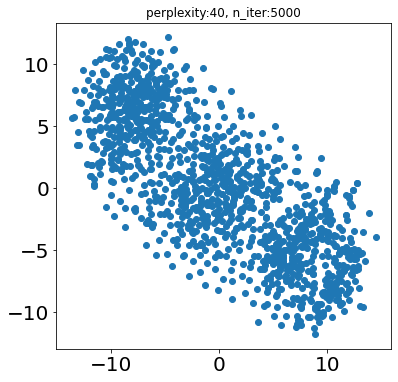

In [46]:
perp_list = [15, 25, 40]
for perplexity in perp_list:
    tsne_result = tsne(n_components=2, verbose=0, perplexity=perplexity, n_iter=5000, init='pca').fit_transform(normalized_read_depth.T)

    fix, ax = plt.subplots(1,1,figsize=(6,6))
    plt.scatter(tsne_result[:,0], tsne_result[:,1])    
    plt.title(f'perplexity:{perplexity}, n_iter:5000')

#### let us pick perplexity = 25

In [47]:
tsne_result = tsne(n_components=2, verbose=1, perplexity=25, n_iter=5000, init='pca').fit_transform(normalized_read_depth.T)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1239 samples in 0.001s...
[t-SNE] Computed neighbors for 1239 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1239
[t-SNE] Computed conditional probabilities for sample 1239 / 1239
[t-SNE] Mean sigma: 0.008506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.872887
[t-SNE] KL divergence after 3600 iterations: 2.024841


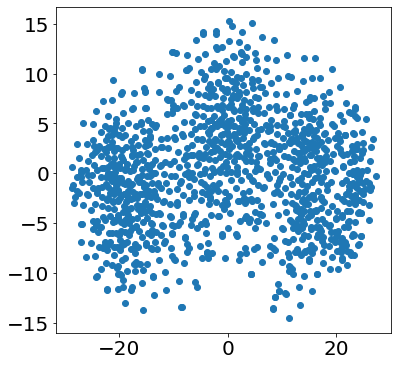

In [48]:
fix, ax = plt.subplots(1,1,figsize=(6,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1])    

In [49]:
tsne_result.shape

(1239, 2)

In [50]:
kmeans_result = kmeans(n_clusters=4).fit(normalized_read_depth.T)

In [76]:
sns.color_palette('Accent_r',10)

[(0.4, 0.4, 0.4),
 (0.7490196078431373, 0.3568627450980392, 0.09019607843137253),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 (1.0, 1.0, 0.6),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.4980392156862745, 0.788235294117647, 0.4980392156862745)]

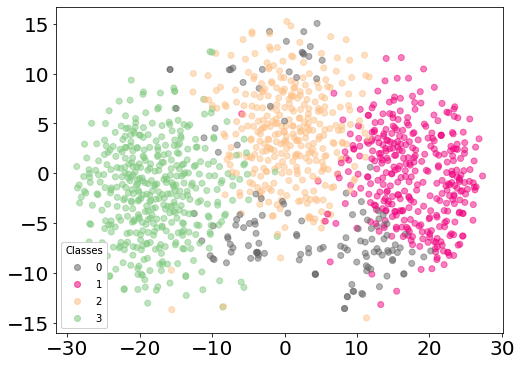

In [98]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
g = plt.scatter(tsne_result[:,0], tsne_result[:,1], c=kmeans_result.labels_, alpha=0.5, cmap='Accent_r')

# produce a legend with the unique colors from the scatter
legend1 = plt.gca().legend(*g.legend_elements(),
                    loc="lower left", title="Classes")
plt.gca().add_artist(legend1)

In [53]:
# Mutz-8, Raji, K562 and Jurkat cells were mixed together at 43%, 26%, 20% and 11% 
pd.Series(kmeans_result.labels_).value_counts()/tsne_result.shape[0]

3    0.334140
1    0.284100
2    0.271186
0    0.110573
dtype: float64

In [57]:
# maybe 0 is Jurkat, 3 is Mutz-8, 2 is K562 and 1 is Raji

In [86]:
cell_colors = [sns.color_palette('Accent_r', 10)[math.floor(3*x)] for x in np.sort(kmeans_result.labels_)]

In [94]:
sns.color_palette('tab10', 22)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

In [95]:
df_unique_pos['chrom']

pos                amplicon chrom ref          alt  ref_len  \
19522  115256669   AML_v2_NRAS_115256512     1   G  GATGCTATTGC        1   
19536  115256683   AML_v2_NRAS_115256512     1   A            C        1   
19555  115258637   AML_v2_NRAS_115258635     1   A            G        1   
2387    25457326  AML_v2_DNMT3A_25457166     2   T            C        1   
2418    25458546  AML_v2_DNMT3A_25458540     2   C            A        1   
...          ...                     ...   ...  ..          ...      ...   
10798   44524605   AML_v2_U2AF1_44524438    21   T            C        1   
10799   44524606   AML_v2_U2AF1_44524438    21   T            C        1   
10800   44524607   AML_v2_U2AF1_44524438    21   A            T        1   
10801   44524608   AML_v2_U2AF1_44524438    21   A            G        1   
10802   44524609   AML_v2_U2AF1_44524438    21   C            A        1   

       alt_len  normal  index  
19522       11   False      1  
19536        1    True      3  
19555        1    True      5  
2387         1    True      7  
2418         1    True      9  
...        ...     ...    ...  
10798        1    True  33433  
10799        1    True  33434  
10800        1    True  33436  
10801        1    True  33437  
10802        1    True  33438  

[23946 rows x 9 columns]

In [102]:
namplicons

127

<ipython-input-101-5447ef023873>:5: RuntimeWarning: divide by zero encountered in true_divide
  scaled_normazlied_read_depth = normalized_read_depth / control_group_median
<ipython-input-101-5447ef023873>:5: RuntimeWarning: invalid value encountered in true_divide
  scaled_normazlied_read_depth = normalized_read_depth / control_group_median


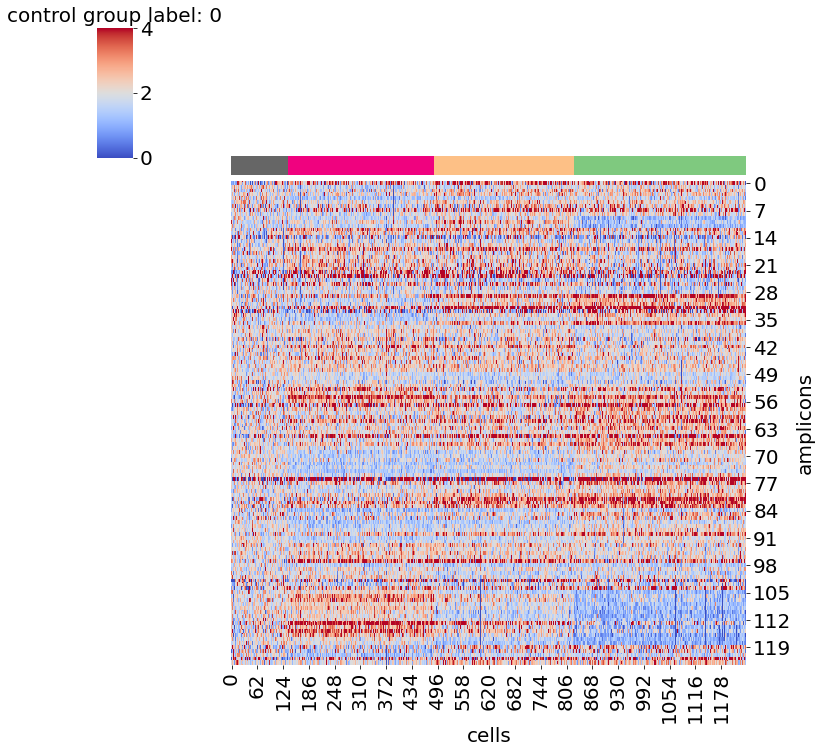

In [101]:
sort_indices = np.argsort(kmeans_result.labels_ )

for control_group_label in [0, 1, 2, 3]:
    control_group_median = np.median(normalized_read_depth[:, np.where(kmeans_result.labels_ == control_group_label)[0]], axis = 1)[:, None]
    scaled_normazlied_read_depth = normalized_read_depth / control_group_median
    
    scaled_normazlied_read_depth = scaled_normazlied_read_depth[:, sort_indices]
#     fig, ax = plt.subplots(1,1,figsize=(6,6))
    g = sns.clustermap(scaled_normazlied_read_depth[~np.isnan(scaled_normazlied_read_depth).any(axis=1)]*2, row_cluster=False, col_cluster=False, vmin=0, vmax=4, cmap='coolwarm', col_colors=cell_colors)
    g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)
    plt.title(f'control group label: {control_group_label}', fontsize=20)
    break

<ipython-input-96-bfe7322c4810>:5: RuntimeWarning: divide by zero encountered in true_divide
  scaled_normazlied_read_depth = normalized_read_depth / control_group_median
<ipython-input-96-bfe7322c4810>:5: RuntimeWarning: invalid value encountered in true_divide
  scaled_normazlied_read_depth = normalized_read_depth / control_group_median


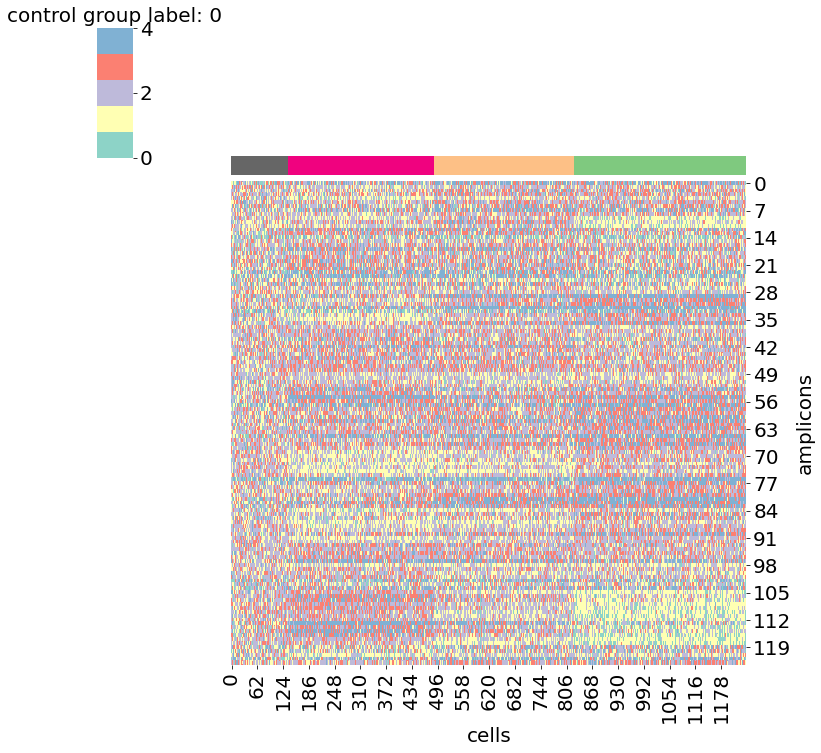

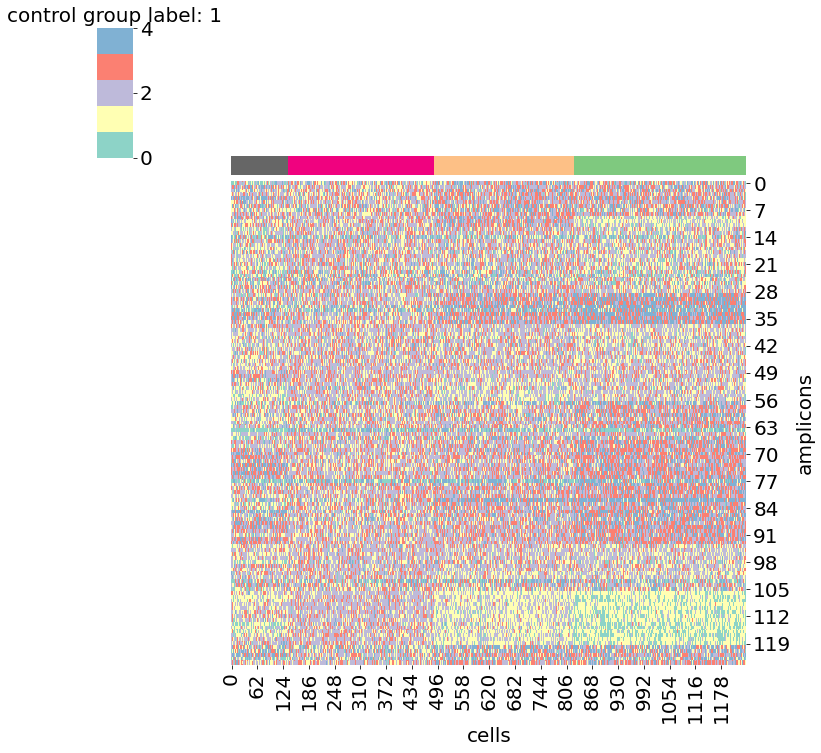

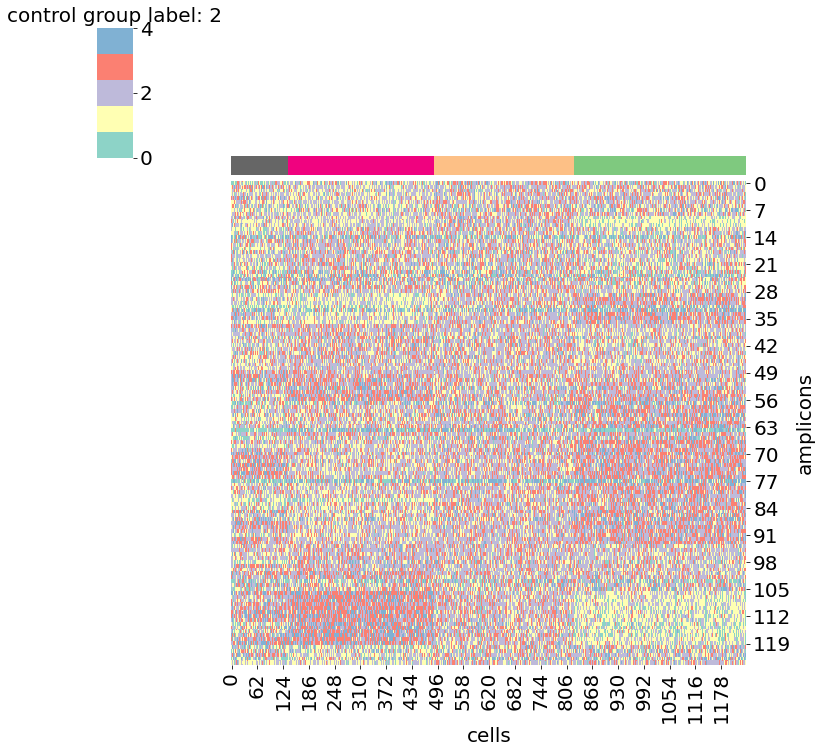

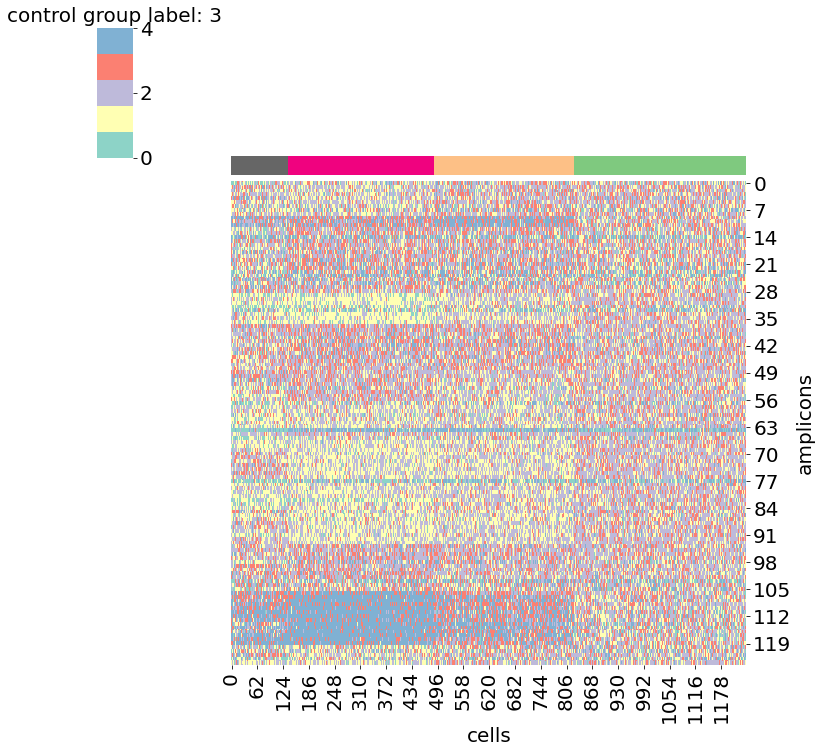

In [96]:
sort_indices = np.argsort(kmeans_result.labels_ )

for control_group_label in [0, 1, 2, 3]:
    control_group_median = np.median(normalized_read_depth[:, np.where(kmeans_result.labels_ == control_group_label)[0]], axis = 1)[:, None]
    scaled_normazlied_read_depth = normalized_read_depth / control_group_median
    
    scaled_normazlied_read_depth = scaled_normazlied_read_depth[:, sort_indices]
#     fig, ax = plt.subplots(1,1,figsize=(6,6))
    g = sns.clustermap(scaled_normazlied_read_depth[~np.isnan(scaled_normazlied_read_depth).any(axis=1)]*2, row_cluster=False, col_cluster=False, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5), col_colors=cell_colors)
    g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)
    plt.title(f'control group label: {control_group_label}', fontsize=20)

<ipython-input-88-791057727873>:5: RuntimeWarning: divide by zero encountered in true_divide
  scaled_normazlied_read_depth = normalized_read_depth / control_group_median
<ipython-input-88-791057727873>:5: RuntimeWarning: invalid value encountered in true_divide
  scaled_normazlied_read_depth = normalized_read_depth / control_group_median


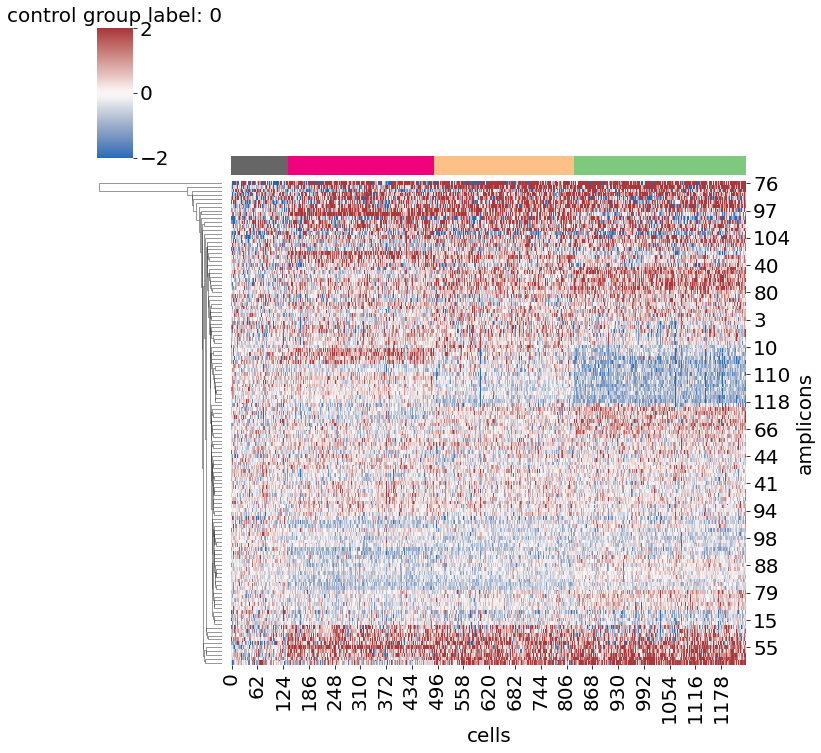

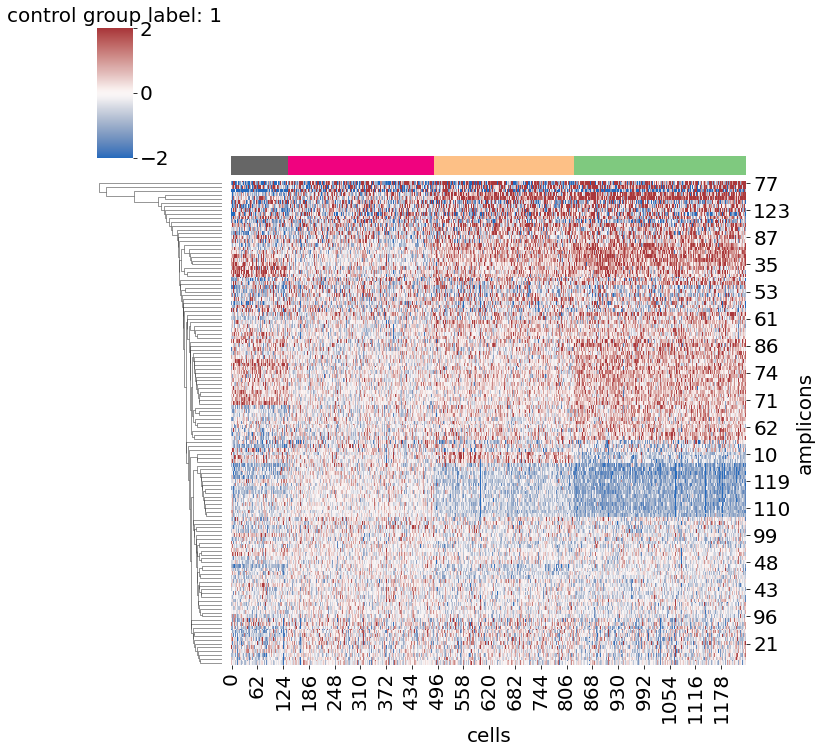

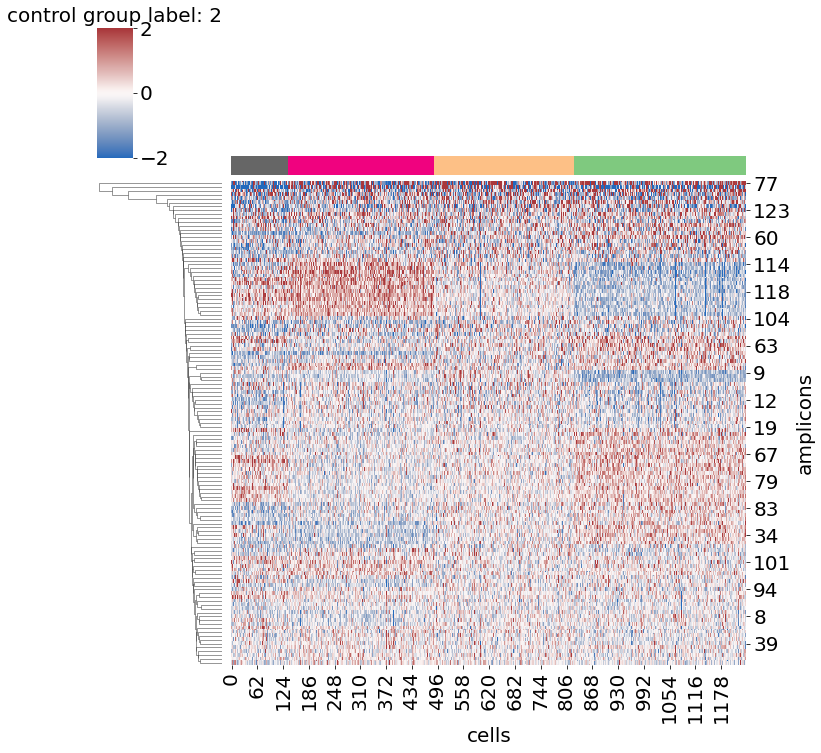

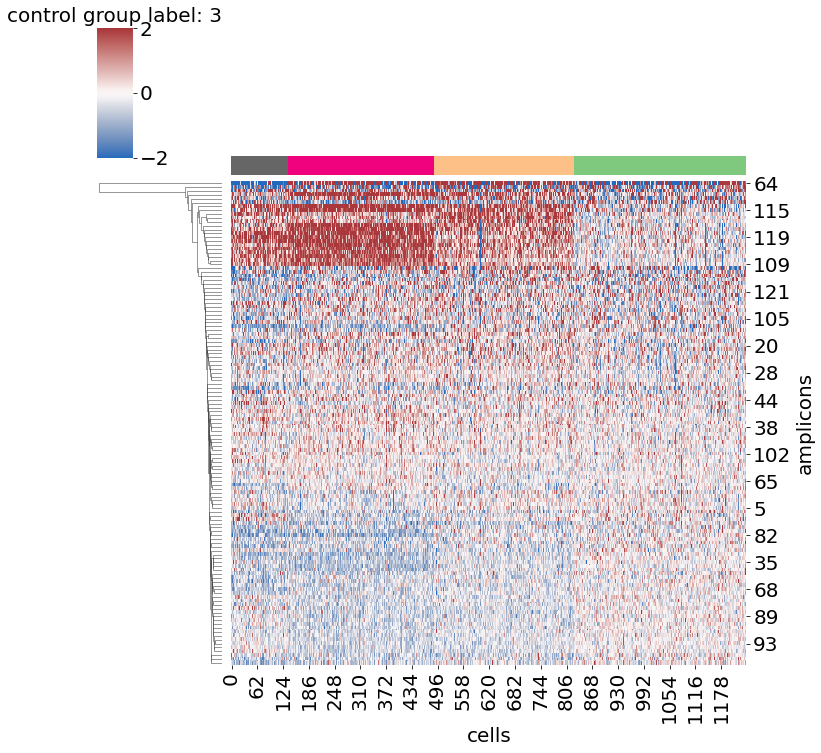

In [88]:
sort_indices = np.argsort(kmeans_result.labels_ )

for control_group_label in [0, 1, 2, 3]:
    control_group_median = np.median(normalized_read_depth[:, np.where(kmeans_result.labels_ == control_group_label)[0]], axis = 1)[:, None]
    scaled_normazlied_read_depth = normalized_read_depth / control_group_median
    
    scaled_normazlied_read_depth = scaled_normazlied_read_depth[:, sort_indices]
#     fig, ax = plt.subplots(1,1,figsize=(6,6))
    g = sns.clustermap(scaled_normazlied_read_depth[~np.isnan(scaled_normazlied_read_depth).any(axis=1)]*2 - 2, row_cluster=True, col_cluster=False, vmin=-2, vmax=2, cmap=sns.color_palette("vlag", as_cmap=True), col_colors=cell_colors)
    g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)
    plt.title(f'control group label: {control_group_label}', fontsize=20)

In [235]:
control_group_median.shape

(127, 1, 209)

In [238]:
normalized_read_depth[:, np.where(kmeans_results.labels_ == control_group_label)[0]].shape

(127, 209)

In [241]:
np.where(kmeans_results.labels_ == control_group_label)[0]

array([   4,    5,   16,   19,   26,   37,   38,   39,   40,   45,   48,
         60,   62,   66,   76,   78,   85,   90,   96,  109,  111,  125,
        137,  143,  149,  163,  164,  168,  171,  175,  179,  193,  198,
        205,  206,  210,  223,  235,  247,  251,  252,  253,  254,  255,
        270,  285,  290,  291,  293,  298,  305,  309,  325,  327,  331,
        334,  335,  339,  344,  350,  353,  354,  361,  366,  368,  378,
        379,  381,  392,  396,  405,  410,  412,  413,  415,  427,  440,
        445,  450,  457,  466,  467,  468,  484,  488,  491,  497,  498,
        500,  502,  504,  512,  514,  516,  520,  521,  522,  523,  527,
        536,  546,  547,  550,  551,  568,  569,  570,  573,  575,  582,
        584,  589,  597,  599,  606,  612,  620,  624,  635,  639,  643,
        645,  648,  653,  655,  665,  670,  674,  679,  681,  686,  689,
        691,  693,  699,  700,  706,  713,  722,  731,  736,  759,  760,
        762,  764,  765,  768,  769,  772,  777,  7

#### back to the read depth heatmaps

In [47]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 40.75, 'cells')

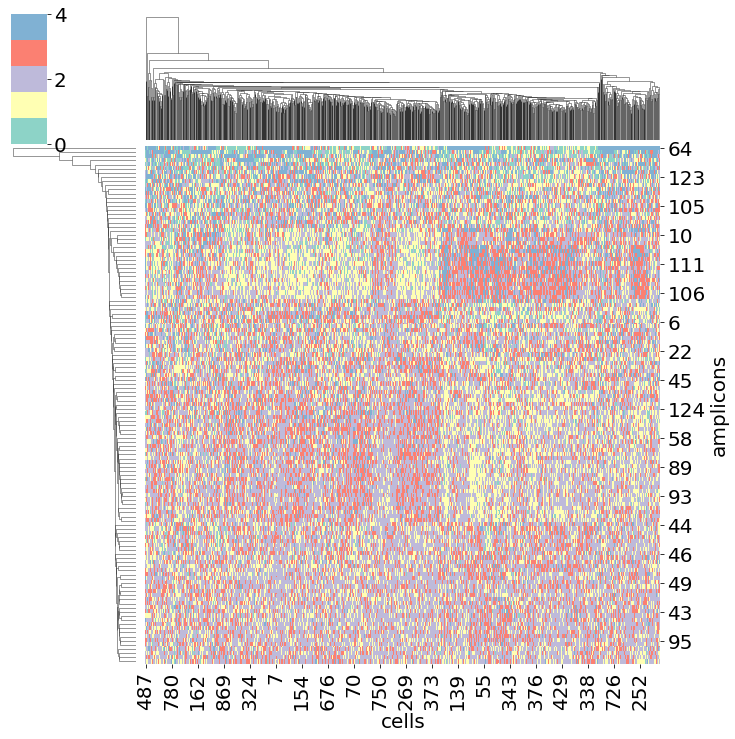

In [58]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [49]:
relative_normalized_read_depth.shape

(125, 1241)

**We filter the cells with low coverage this time**

In [50]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0.8, read_depth_threshold = 10)

In [51]:
read_depth.shape

(127, 951)

In [52]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 40.75, 'cells')

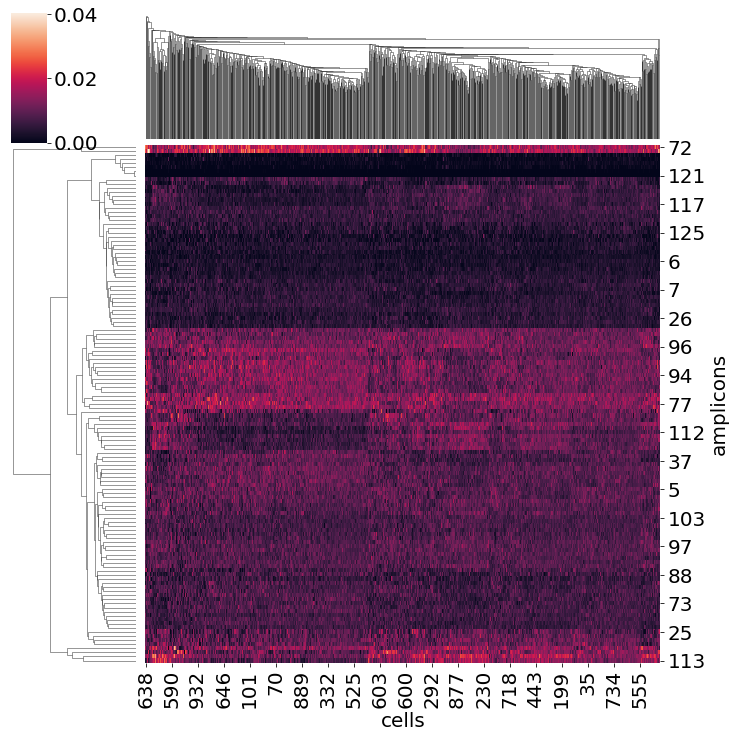

In [57]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [54]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 40.75, 'cells')

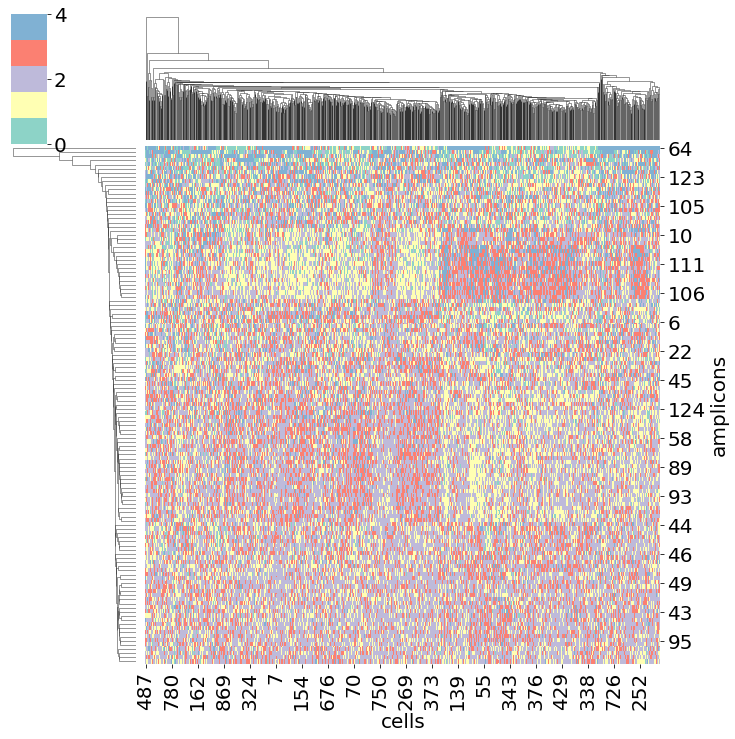

In [56]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### can we extracat normal cells?

we will try to use SNVs for this

In [59]:
def get_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.1):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # remove positions with total read depth less than read_depth_threshold
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove positions with max vaf less than vaf_threshold
    return vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]

In [64]:
vaf_mat = get_vaf_matrix(vaf_threshold = 0.05, read_depth_threshold=0) # a bit more strict with the vaf_threshold here

<ipython-input-59-e32cb90cd692>:18: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
<ipython-input-59-e32cb90cd692>:16: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [65]:
vaf_mat.shape

(2977, 1241)

Text(0.5, 28.0, 'cells')

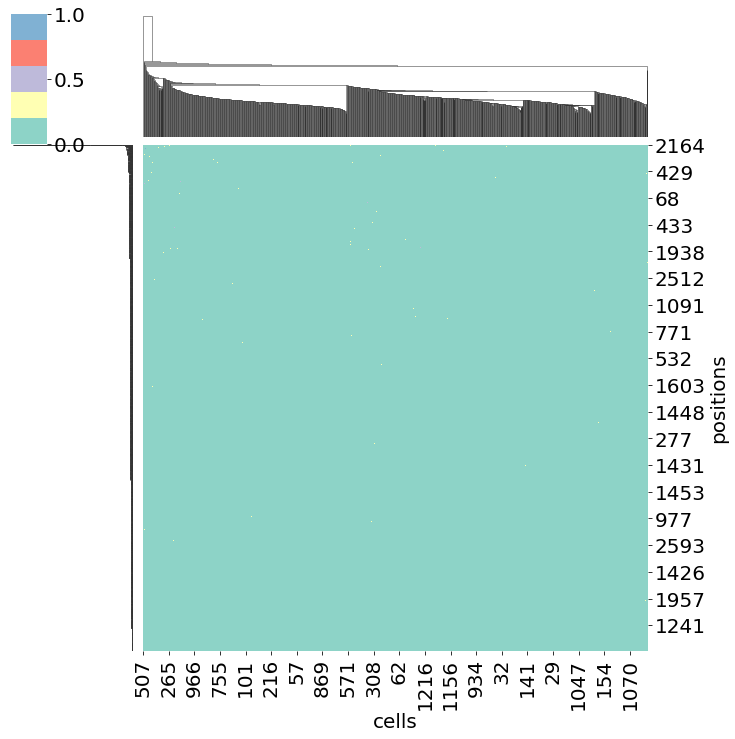

In [66]:
g = sns.clustermap(vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [69]:
filtered_vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) >= 0.01, :]

In [70]:
filtered_vaf_mat.shape

(32, 1241)

Text(0.5, 28.0, 'cells')

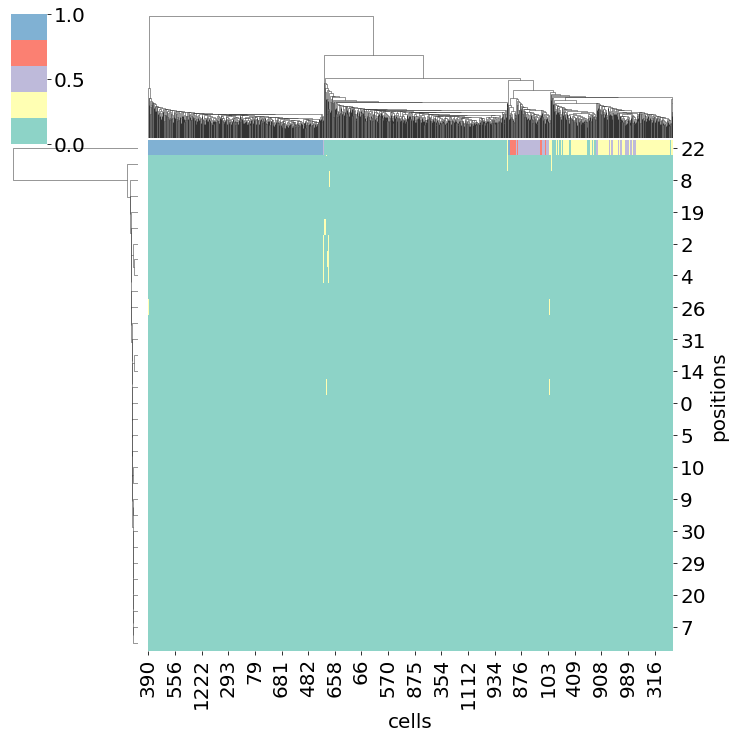

In [71]:
g = sns.clustermap(filtered_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

What are these positions that are mutated in all the cells? Could it be SNPs? <br>
**TODO: download dbsnp database and cross-reference those positions** <br>
Quick fix: remove positions wtih median VAF across all cells more than 0.1

In [72]:
vaf_threshold = 0.1
filtered_vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) <= vaf_threshold, :]

In [73]:
filtered_vaf_mat.shape

(2976, 1241)

Text(0.5, 28.0, 'cells')

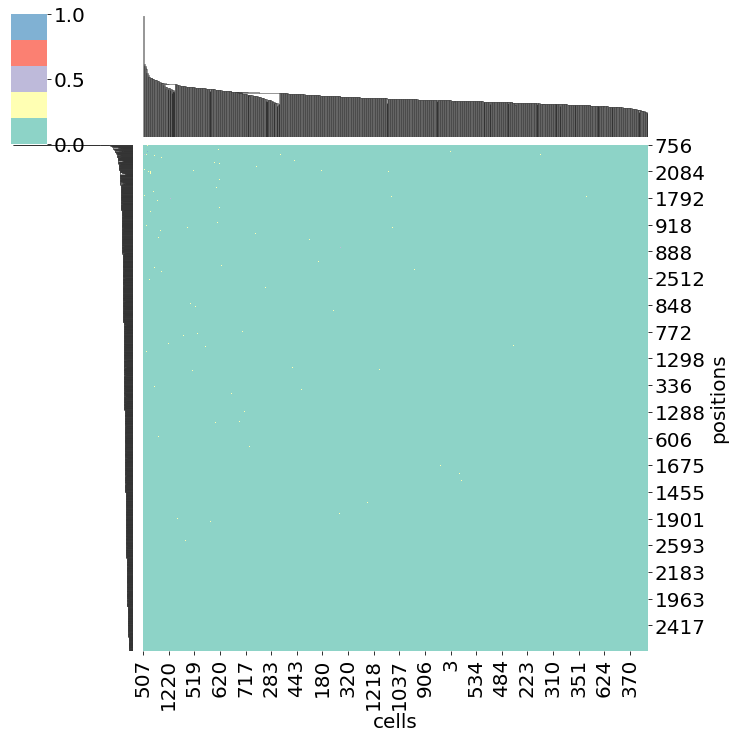

In [74]:
g = sns.clustermap(filtered_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

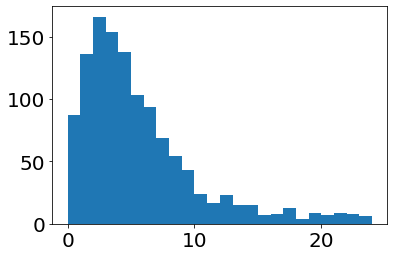

In [75]:
plt.hist(np.sum(filtered_vaf_mat > vaf_threshold, axis = 0), bins = np.arange(25));

In [76]:
print(f'tentative number of normal cells: {sum(np.sum(filtered_vaf_mat > vaf_threshold, axis = 0) == 0)}')

tentative number of normal cells: 87


**Plan: Use these normal cells to normalize total read counts and get copy numbers**

In [77]:
def get_normal_cell_indices(read_depth_threshold = 10, vaf_threshold = 0.1):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove uninformative positions
    vaf_mat = vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]
    
    # remove likely SNP positions
    vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) <= vaf_threshold, :]
    
    # count number of positions with VAF over the thershold for each cell
    position_count = np.sum(filtered_vaf_mat > vaf_threshold, axis = 0)
    
    return np.where(position_count == 0)[0]

In [78]:
normal_cell_indices = get_normal_cell_indices()

In [79]:
normal_cell_indices.shape

(87,)

In [80]:
normal_cell_indices

array([   9,   52,   65,   69,   88,  100,  102,  127,  146,  163,  173,
        198,  200,  219,  230,  241,  251,  255,  304,  313,  317,  322,
        339,  361,  363,  365,  369,  370,  407,  408,  415,  435,  445,
        476,  505,  523,  532,  545,  548,  583,  584,  616,  634,  651,
        664,  670,  671,  692,  695,  739,  740,  758,  764,  789,  801,
        816,  831,  839,  855,  910,  921,  926,  930,  967,  971,  984,
        998,  999, 1001, 1002, 1071, 1082, 1092, 1098, 1101, 1110, 1114,
       1126, 1128, 1132, 1139, 1153, 1191, 1196, 1207, 1221, 1237])

**Trying out these normal cells for read count normalization!**

In [81]:
def get_relative_read_depth(normal_cell_indices, amplicon_threshold = 0.8, trim_perc = 0, read_depth_threshold = 10):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # remove amplicons with median read depth acorss all cells equal to 0
    read_depth = read_depth[np.median(read_depth, axis = 1) > 0, :]
    
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    normal_normalized_read_depth = normalized_read_depth[:, normal_cell_indices]
    normal_normalized_read_depth_median = np.median(normal_normalized_read_depth, axis=1)[:, None]
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    # further normalize by the median read count of each amplicon in the normal cells
    relative_normal_normalized_read_depth = normalized_read_depth / normal_normalized_read_depth_median
    
    return relative_normal_normalized_read_depth

In [82]:
relative_normal_normalized_read_depth = get_relative_read_depth(normal_cell_indices)

In [83]:
relative_normal_normalized_read_depth.shape

(125, 951)

Text(0.5, 40.75, 'cells')

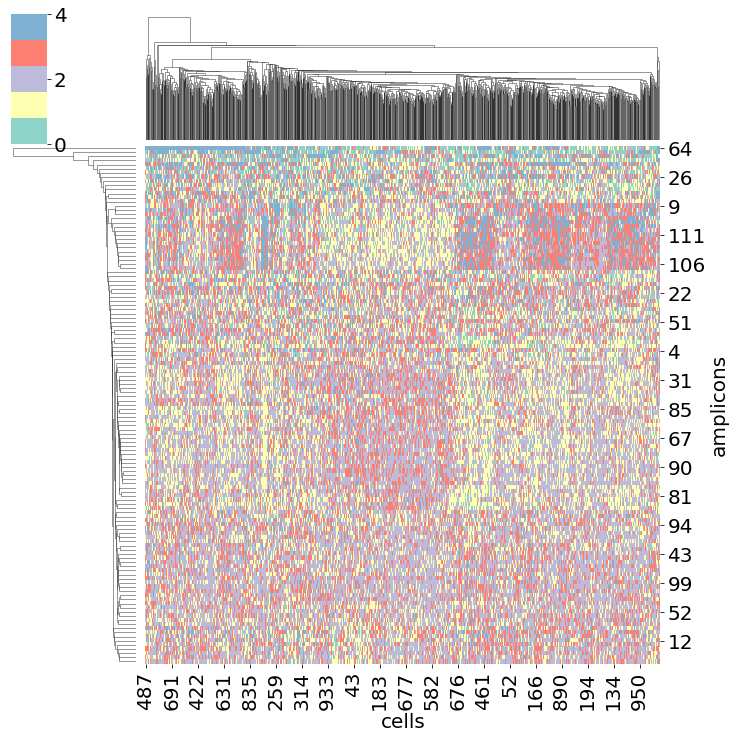

In [84]:
g = sns.clustermap(relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [85]:
relative_normal_normalized_read_depth = get_relative_read_depth(normal_cell_indices, amplicon_threshold=0, read_depth_threshold=0)

Text(0.5, 28.0, 'cells')

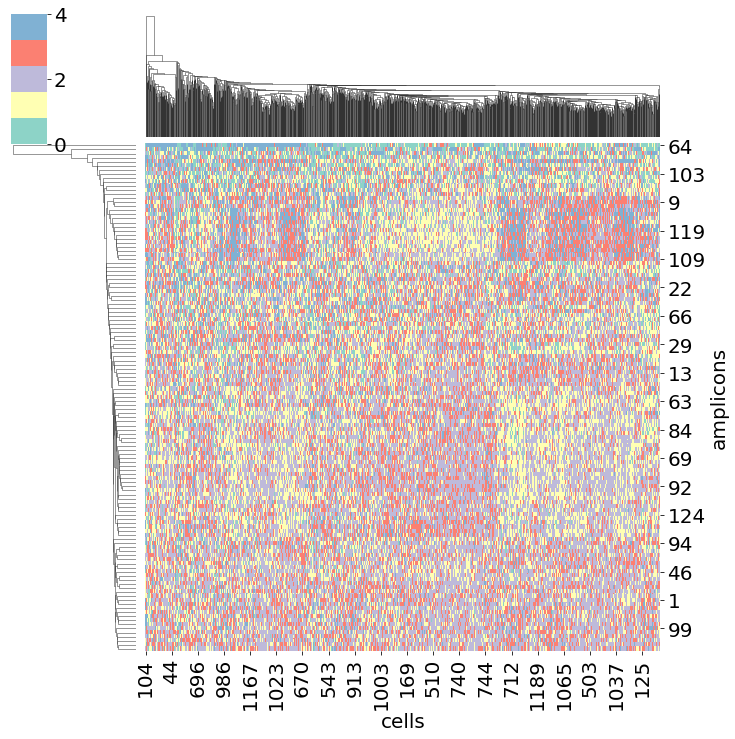

In [86]:
g = sns.clustermap(relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### construct condensed VAF matrix

In [87]:
def get_condensed_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.1, presence_threshold = 0.05):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # remove positions with total read depth less than read_depth_threshold
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove positions with max vaf less than vaf_threshold
    vaf_mat = vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]
    
    # remove positions with vaf less than vaf_threshold in less than presense_threshold fraction of the cells
    ncells = vaf_mat.shape[1]
    vaf_threshold_cell_count = (vaf_mat >= vaf_threshold).sum(axis = 1)
    return vaf_mat[vaf_threshold_cell_count >= presence_threshold*ncells, :]

In [91]:
condensed_vaf_mat = get_condensed_vaf_matrix(read_depth_threshold=0) 

<ipython-input-87-49fc8e39986d>:18: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
<ipython-input-87-49fc8e39986d>:16: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [92]:
condensed_vaf_mat.shape

(3, 1241)

Text(0.5, 28.0, 'cells')

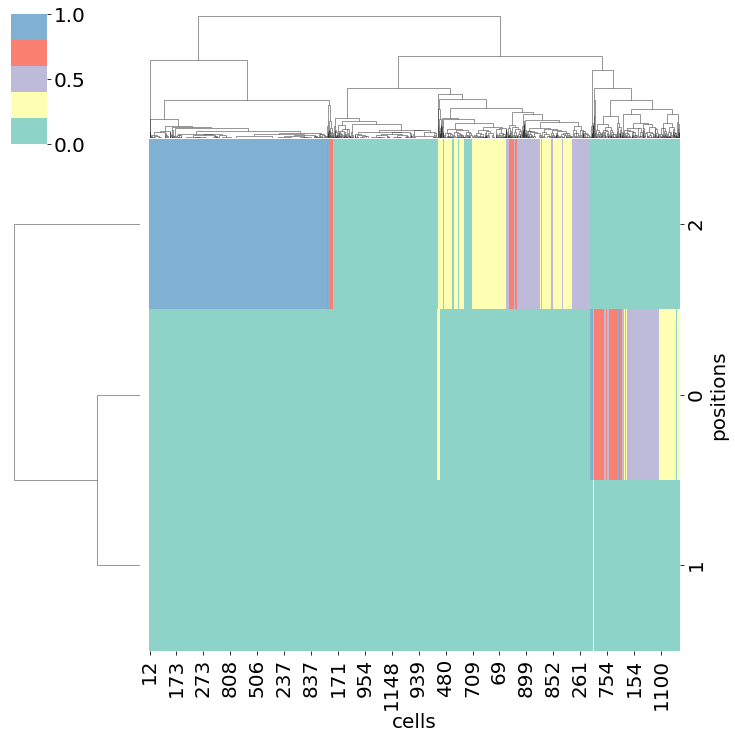

In [93]:
g = sns.clustermap(condensed_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)